# Messy File - RegEx

## 1) Objective


We want to return to our messy file, but this time we would like to extract the sensor labels. Also here, we see that the sensor labels are not consistent. 

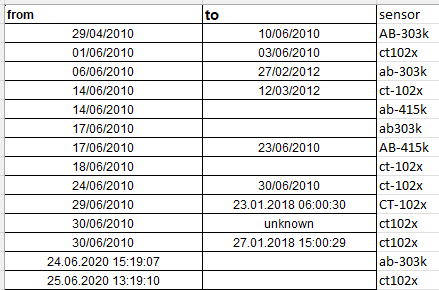

Even the date itself is not labelled as such!

<br>

## 2) Preparation

First, we call the standard libraries as before.

In [ ]:
import numpy as np
import pandas as pd

Next, we call a .py script that contains a few helper functions - one that turns a dataframe into an interactive table and another helper function that is just *FindMyFile* from the previous example. 

In [ ]:
from MessyFileAux import *

Therefore, we call the messy file:

In [ ]:
Data = pd.read_excel(FindMyFile('MessyFile.xlsx'))
print(Data.head)

We also need to call two more libraries for this exercise, one for **fuzzy match** and one for regular expression or **RegEx**.

In [ ]:
import re 
from rapidfuzz import fuzz

<br>

## 3) Fuzzy Match

A helpful tool for dealing with inconsitent keywords and search strings is **fuzzy match**, that allows some variance in the string search. Lets consider the actual search string we are looking for, but the expression in the file *x*, might not contain the exact consistent search string and some other, irrelevant token, for example:   

In [ ]:
search_string = 'ab-415k'
x             = 'this is sensor 415K series ab'

Fuzzy match has four methods that returns the fraction of identical sides. Note, that fuzzy match **does not** run an actual sequence alignment like *Smith - Waterman*, *Needleman-Wunsch* or *repeated matches*. It just counts the identical sides - but you can pick four different methods: 

In [ ]:
#1) ratio: just returns the ratio of identical sides
fuzz.ratio(x.lower(), search_string.lower())#22%

In [ ]:
#2) partial ratio: the search string can be somewhere in x, i.e we need to
#pick the most similar part and calculate the ratio from that
fuzz.partial_ratio(x.lower(), search_string.lower())#57%

In [ ]:
#3) token sort ratio: token, i.e. letters and words, could be in different order
fuzz.token_sort_ratio(x.lower(), search_string.lower())#22%

In [ ]:
#4) token set ratio: calculates ratio on subset strings
fuzz.token_set_ratio(x.lower(), search_string.lower())#22

For example, we can try all for different methods for a particular string, in order to get an idea of the efficiency.

In [ ]:
x1 = 'this is sensor 415K series ab'
x2 = 'this is sensor 415K ab'
x3 = 'this is sensor ab 415K'

X = [x1, x2, x3]

In [ ]:
for x in X:
    f1 = fuzz.ratio(           x.lower(), search_string.lower())
    f2 = fuzz.partial_ratio(   x.lower(), search_string.lower())
    f3 = fuzz.token_sort_ratio(x.lower(), search_string.lower())
    f4 = fuzz.token_set_ratio( x.lower(), search_string.lower())
    
    print(f"fuzz ratio = {f1: .2f}%\nfuzz partial ratio = {f2: .2f}%\n" + 
          f"fuzz token sort ratio = {f3: .2f}%\nfuzz token set ratio = {f4: .2f}%\n")

Let us experiment with a more dynamic approach:

In [ ]:
def FuzzyMatch(series, search_string: str, method: str = 'partial_ratio', threshold: float = 80):
    """
    returns rows idx where fuzz search found match > threshold
    methods: ratio
             partial_ratio
             token_sort_ratio
             token_set_ratio
    """
    M         = getattr(fuzz, method)  # runs fuzz match
    Mfun      = lambda x: M(x.lower(), search_string.lower()) >= threshold # defines function runs fuzz match and 
                                                                           # returns True | False if match is above threshols 
    TrueFalse = series.fillna("").astype(str).apply(Mfun) # applies Mfun to df column (which is a series)
    
    return np.argwhere(TrueFalse == True).reshape(-1)

In [ ]:
Methods = ['ratio',
           'partial_ratio',
           'token_sort_ratio',
           'token_set_ratio']

In [ ]:
for m in Methods:
    idx = FuzzyMatch(Data['sensor'], 'CT-102x', method = m)
    print('method: '+ m + '\n')
    print(Data.iloc[idx,:3])
    print('----------------------------------------------------\n')
    print('----------------------------------------------------\n')

Fuzzy match is very flexible, but in some cases not specific, because we just set a threshold that might work for some files, but not for other filese. Therefore, we might get false positives or miss entries. In many cases however, we have an idea of the string we have to look for, which leads us to **RegEx**.  

<br>

## 4) RegEx

Using ReGex, we can specificly set certain constrains that apply for the search string. For example we might know that a serial number of a device always starts with the string *AAA*. Therefore, we can specificly search for such a pattern.<br>
The RegEx library in *Python* provides four main *functions*, a large set of so called *"Metacharacters"* and *flags*, which all can be combined to a more targeted search.

**4.1) RegEx Functions**

Here is an overview of the four different functions. Run the cells below and edit the examples. Make sure that you understand the syntax and try to predict the output before you press the *"run"* button.

In [ ]:
# RegEx table: Functions
RegExFun = pd.DataFrame({
    'Function': ["findall", "search", "split", "sub"],
    'What It Does': [
        'returns a list of all matches',
        'returns location of the first(!) character',
        'splits string based on "c1" and returns a list',
        'searches "c1" and replaces it by "c2"'
    ],
    'Example': [
        'print(re.findall("a", "How many a-s are in Alabama?"))',
        'out = re.search("a", "How many a-s are in Alabama?")\nprint(out.span()[0])', 
        'print(re.split(" ", "Split this string based on spaces!"))',
        'print(re.sub("a", "A", "How many a-s are in Alabama?"))'
    ]
})

In [ ]:
ShowInteractiveTable(RegExFun)

<br>

**4.2) RegEx Metacharacters**

We can combine the functions with so called "Metacharacters", that helps us to search for very particular combinations of characters. The following table shows the most common "Metacharacters".<br> 
Run the cells below and edit the examples. Make sure that you understand the syntax and try to predict the output before you press the "run" button. 

In [ ]:
# RegEx table
RegExMeta = pd.DataFrame({
    'Character': ["[ ]", "\\", ".", "^", "$", "{ }", "|"],
    'What It Does': [
        'matches all characters (case sensitive) alphabetically between "c1" and "c2"',
        'matches all special characters indicated by "\" ("\d" all digit, "\w" all letters etc)',
        'match any character except a newline',
        'starts with',
        'ends with',
        'matches sequence that starts with "c1", followed by excactly n characters, and an "c2"',
        'logical or'
    ],
    'Example': [
        'print(re.findall("[c-f]", "All Men must die"))',
        'print(re.findall("\d", "sensor AB-404"))',
        'print(re.findall(".", "AB-404"))',
        'print(re.findall("^AB", "AB-404"))',
        'print(re.findall("AB$", "sensor 404, version AB"))',
        'print(re.findall("2.{2}k", "sensors: 200k, 234k, 211k, 533k, 277k, 544c"))',
        'print(re.findall("200k|200k", "sensors: 200k, 234k, 211k, 533k, 277k, 544c"))'
    ]
})

In [ ]:
ShowInteractiveTable(RegExMeta)

<br>

**4.3) RegEx Flags**

For a more precise search (such as case sensitive, ascii only etc) and data extraction, one can add so called *"flags"* to the statements we discussed above. The following table shows the most common flags.

In [ ]:
# RegEx table
RegExFlag = pd.DataFrame({
    'Flag': ['ASCII or A', 'DEBUG', 'DOTALL or S'],
    'What It Does': [
        'returns only ASCII characters', 
        'debugs information',
        'searches for c1 followed by a symbol (one) and ends with c2',
    ],
    'Example': [
        'print(re.findall("\w", "Pößneck is a town in Germany.", re.A))', # test using re.A vs no flag! 
        'print(re.findall("\w", "Pößneck is a town in Germany.", re.DEBUG))',
        'print(re.findall("o.n", "This town has been known to be my own oxygen", re.S))',
    ]
})

In [ ]:
ShowInteractiveTable(RegExFlag)

RegEx offers even more tools, such as searching for **special sequences** and entire **sets**!